In [1]:
import pandas as pd
import numpy as np

import librosa
import librosa.display

# To play sound in the notebook
import IPython.display as ipd  
from IPython.display import Audio
import soundfile as sf

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import specgram
import seaborn as sns
sns.set()

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

# interface with underlying OS that python is running on
import os 
import sys

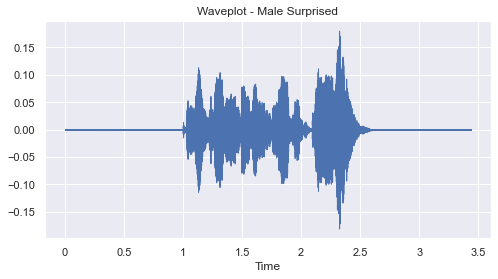

In [45]:
# LOAD IN FILE
x, sr = librosa.load('/Volumes/SD Card/Datasets/RAVDESS/Actor_07/03-01-08-02-02-01-07.wav')

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Surprised');

# PLAY AUDIO FILE
Audio(data=x, rate=sr)

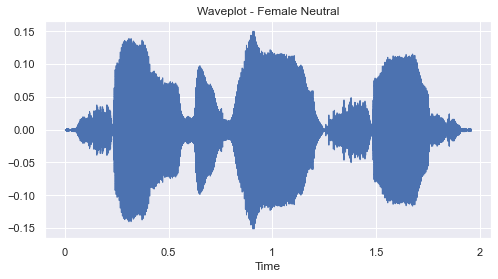

In [46]:
x, sr = librosa.load('/Volumes/SD Card/Datasets/TESS/YAF_neutral/YAF_should_neutral.wav')

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Neutral');

# PLAY AUDIO FILE
Audio(data=x, rate=sr)

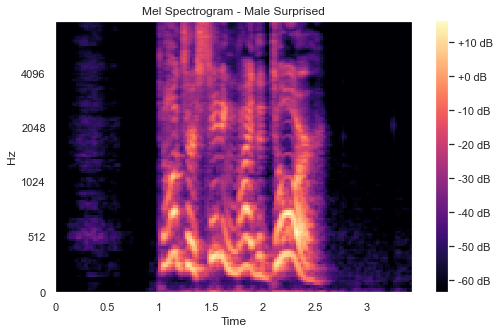

In [5]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

widthHeight = (8, 5)
plt.figure(figsize=widthHeight)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Male Surprised');
plt.colorbar(format='%+2.0f dB');

In [6]:
# directories that have subfiles (change them to your own)
Ravdess = "/Volumes/SD Card/Datasets/RAVDESS/" 
Tess = "/Volumes/SD Card/Datasets/TESS/"  

# no subfiles
Crema_D = "/Volumes/SD Card/Datasets/CREMA-D/"
Savee = "/Volumes/SD Card/Datasets/SAVEE/"

In [7]:
# accessing inner files in RAVDESS
Ravdess_dir_list = [x for x in os.listdir(Ravdess) if not x.startswith('.')]
print('Ravdess:\n', sorted(Ravdess_dir_list))

Ravdess:
 ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [8]:
# creating lists for df columns
emotion = []
gender = []
location = []

for actor_file in Ravdess_dir_list: #iterate over inner folders
    actor_wavs = [x for x in os.listdir(Ravdess + '/' + actor_file) if not x.startswith('.')]
    
    for wav in actor_wavs: #iterate over wav files
        partition = wav.split('-')
        emotion_num = int(partition[2])
        
        emotion.append(emotion_num)
        actor_num = int(partition[6].split('.')[0])
        
        if (actor_num%2 == 0): gender.append('female')
        else: gender.append('male')
        
        location.append(Ravdess + actor_file + '/' + wav)

#initializing dataframe
Ravdess_df = pd.DataFrame({'gender': gender, 'emotion': emotion, 'location': location },
                          columns=['gender','emotion', 'location'])

#swapping numerical value to a label
Ravdess_df = Ravdess_df.replace({"emotion": {1:'neutral', 2:'calm', 3:'happy', 4:'sad',
                                5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}})
print(Ravdess_df.shape)
Ravdess_df

(1440, 3)


,gender,emotion,location
0,female,angry,/Volumes/SD Card/Datasets/RAVDESS/Actor_16/03-...
1,female,fear,/Volumes/SD Card/Datasets/RAVDESS/Actor_16/03-...
2,female,fear,/Volumes/SD Card/Datasets/RAVDESS/Actor_16/03-...
3,female,angry,/Volumes/SD Card/Datasets/RAVDESS/Actor_16/03-...
4,female,disgust,/Volumes/SD Card/Datasets/RAVDESS/Actor_16/03-...
...,...,...,...
1435,female,happy,/Volumes/SD Card/Datasets/RAVDESS/Actor_08/03-...
1436,female,happy,/Volumes/SD Card/Datasets/RAVDESS/Actor_08/03-...
1437,female,calm,/Volumes/SD Card/Datasets/RAVDESS/Actor_08/03-...
1438,female,calm,/Volumes/SD Card/Datasets/RAVDESS/Actor_08/03-...


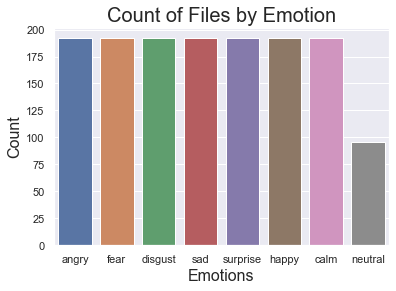

angry       192
calm        192
happy       192
surprise    192
disgust     192
sad         192
fear        192
neutral      96
Name: emotion, dtype: int64

In [9]:
# plot number of emotions for RAVDESS
plt.title('Count of Files by Emotion', size=20)
sns.countplot(Ravdess_df.emotion)

plt.ylabel('Count', size=16)
plt.xlabel('Emotions', size=16)

plt.show()
Ravdess_df.emotion.value_counts()

In [10]:
# accessing inner files in TESS
Tess_dir_list = [x for x in os.listdir(Tess) if not x.startswith('.')]
print('Tess:\n', Tess_dir_list)

Tess:
 ['YAF_disgust', 'OAF_Pleasant_surprise', 'OAF_happy', 'YAF_sad', 'YAF_happy', 'YAF_neutral', 'OAF_Fear', 'OAF_angry', 'YAF_pleasant_surprised', 'YAF_fear', 'OAF_neutral', 'OAF_disgust', 'YAF_angry', 'OAF_Sad']


In [11]:
# same process for Tess dataset
emotion = []
gender = []
location = []

for actor_file in Tess_dir_list: #iterate over inner folders
    actor_wavs = [x for x in os.listdir(Tess + '/' + actor_file) if not x.startswith('.')]
    
    for wav in actor_wavs: #iterate over wav files
        partition = actor_wavs[0].split('_')
        emotion_ = partition[2].split('.')[0]
        
        emotion.append(emotion_)
        gender.append('female')
        location.append(Tess + actor_file + '/' + wav)

#initializing dataframe
Tess_df = pd.DataFrame({'gender': gender, 'emotion': emotion, 'location': location },
                       columns=['gender','emotion','location'])

#swapping 'ps' to 'pleasant surprise' 
Tess_df = Tess_df.replace({"emotion": {'ps':'pleasant surprise'}})
Tess_df

,gender,emotion,location
0,female,disgust,/Volumes/SD Card/Datasets/TESS/YAF_disgust/YAF...
1,female,disgust,/Volumes/SD Card/Datasets/TESS/YAF_disgust/YAF...
2,female,disgust,/Volumes/SD Card/Datasets/TESS/YAF_disgust/YAF...
3,female,disgust,/Volumes/SD Card/Datasets/TESS/YAF_disgust/YAF...
4,female,disgust,/Volumes/SD Card/Datasets/TESS/YAF_disgust/YAF...
...,...,...,...
2795,female,sad,/Volumes/SD Card/Datasets/TESS/OAF_Sad/OAF_too...
2796,female,sad,/Volumes/SD Card/Datasets/TESS/OAF_Sad/OAF_goo...
2797,female,sad,/Volumes/SD Card/Datasets/TESS/OAF_Sad/OAF_met...
2798,female,sad,/Volumes/SD Card/Datasets/TESS/OAF_Sad/OAF_pea...


In [12]:
print(Tess_df.shape)
Tess_df.emotion.value_counts()

(2800, 3)


pleasant surprise    400
happy                400
sad                  400
fear                 400
angry                400
neutral              400
disgust              400
Name: emotion, dtype: int64

In [13]:
# creating dictionary from CREMA github documentation on actors' gender
Crema_genders = pd.read_csv('/Users/hussam/Desktop/VASA exp/actor_gender.csv')
select_cond = ['ActorID', 'Sex']

# looks like this: {1001: 'female'}
extraction = Crema_genders[select_cond]
extraction_dict = dict(extraction.values)

In [14]:
# processing CREMA Dataset

emotion = []
intensity = []
gender = []
location = []

wavs = [x for x in os.listdir(Crema_D) if not x.startswith('.')]

for wav in wavs:
    partition = wav.split('_')
    
    emotion_ = partition[2]
    intensity_ = partition[3].split('.')[0]
    actor_ID = int(partition[0])
    
    # looks up the dictionary made in prev cell
    if actor_ID in extraction_dict: gender.append(extraction_dict.get(actor_ID))
    
    intensity.append(intensity_)
    emotion.append(emotion_) 
    location.append(Crema_D + wav)

Crema_df = pd.DataFrame({'gender': gender, 'emotion': emotion, 'intensity': intensity, 'location': location}, 
                            columns=['gender','emotion', 'intensity', 'location'])

Crema_df = Crema_df.replace({"emotion": {'ANG':'angry','DIS': 'disgust','FEA': 'fear','HAP': 'happy',
                                         'NEU': 'neutral','SAD': 'sad'}})

Crema_df = Crema_df.replace({"intensity": {'LO': 'low','MD': 'medium','HI': 'high','XX': 'unspecified'}})                           

print(Crema_df.intensity.value_counts())
print(Crema_df.emotion.value_counts())
print(Crema_df.shape)
Crema_df

unspecified    6077
high            455
medium          455
low             455
Name: intensity, dtype: int64
happy      1271
fear       1271
angry      1271
disgust    1271
sad        1271
neutral    1087
Name: emotion, dtype: int64
(7442, 4)


,gender,emotion,intensity,location
0,Male,angry,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1022_ITS_ANG...
1,Female,angry,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1037_ITS_ANG...
2,Female,neutral,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1060_ITS_NEU...
3,Female,neutral,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1075_ITS_NEU...
4,Female,disgust,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1073_IOM_DIS...
...,...,...,...,...
7437,Female,angry,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1025_IWW_ANG...
7438,Female,angry,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1030_IWW_ANG...
7439,Male,angry,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1019_TIE_ANG...
7440,Female,neutral,unspecified,/Volumes/SD Card/Datasets/CREMA-D/1079_IEO_NEU...


In [15]:
# processing SAVEE dataset

location = []
gender = []
emotion = []

wavs = [x for x in os.listdir(Savee) if not x.startswith('.')]

for wav in wavs:
    partition = wav.split('_')
    emotion_ = partition[1].split('.')[0]
    emotion_ = ''.join(i for i in emotion_ if not i.isdigit())
    
    emotion.append(emotion_)
    gender.append('male')
    location.append(Savee + wav)

Savee_df = pd.DataFrame({'gender': gender, 'emotion': emotion, 'location': location},
                        columns=['gender','emotion','location'])

Savee_df = Savee_df.replace({"emotion": {'a':'angry','d': 'disgust','f': 'fear','h': 'happy',
                                         'n': 'neutral','sa': 'sad', 'su': 'surprise'}})
print(Savee_df.shape)
print(Savee_df.emotion.value_counts())
Savee_df

(480, 3)
neutral     120
angry        60
disgust      60
sad          60
happy        60
fear         60
surprise     60
Name: emotion, dtype: int64


,gender,emotion,location
0,male,sad,/Volumes/SD Card/Datasets/SAVEE/JK_sa01.wav
1,male,sad,/Volumes/SD Card/Datasets/SAVEE/JK_sa15.wav
2,male,neutral,/Volumes/SD Card/Datasets/SAVEE/DC_n13.wav
3,male,surprise,/Volumes/SD Card/Datasets/SAVEE/DC_su09.wav
4,male,neutral,/Volumes/SD Card/Datasets/SAVEE/DC_n07.wav
...,...,...,...
475,male,angry,/Volumes/SD Card/Datasets/SAVEE/JE_a01.wav
476,male,angry,/Volumes/SD Card/Datasets/SAVEE/JE_a15.wav
477,male,neutral,/Volumes/SD Card/Datasets/SAVEE/DC_n22.wav
478,male,surprise,/Volumes/SD Card/Datasets/SAVEE/DC_su04.wav


In [38]:
# merging all dataframes 
frames = [Savee_df, Tess_df, Ravdess_df, Crema_df]
combined_df = pd.concat(frames)
combined_df.fillna('unspecified')

,gender,emotion,location,intensity
0,male,sad,/Volumes/SD Card/Datasets/SAVEE/JK_sa01.wav,unspecified
1,male,sad,/Volumes/SD Card/Datasets/SAVEE/JK_sa15.wav,unspecified
2,male,neutral,/Volumes/SD Card/Datasets/SAVEE/DC_n13.wav,unspecified
3,male,surprise,/Volumes/SD Card/Datasets/SAVEE/DC_su09.wav,unspecified
4,male,neutral,/Volumes/SD Card/Datasets/SAVEE/DC_n07.wav,unspecified
...,...,...,...,...
7437,Female,angry,/Volumes/SD Card/Datasets/CREMA-D/1025_IWW_ANG...,unspecified
7438,Female,angry,/Volumes/SD Card/Datasets/CREMA-D/1030_IWW_ANG...,unspecified
7439,Male,angry,/Volumes/SD Card/Datasets/CREMA-D/1019_TIE_ANG...,unspecified
7440,Female,neutral,/Volumes/SD Card/Datasets/CREMA-D/1079_IEO_NEU...,unspecified


In [67]:
# data extraction (experiment)
locations = list(combined_df['location'])
specto_df = pd.DataFrame(columns=['mel_spectrogram'])

counter = 0
for path in locations[:1]:
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', sr=44100)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)
 
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    specto_df.loc[counter] = [log_spectrogram]
    counter += 1

specto_df['mel_spectrogram'].to_list()

[array([-31.619865, -36.372856, -42.626842, -42.44423 , -42.349304,
        -42.766735, -42.834023, -42.458588, -42.732513, -43.09911 ,
        -43.359   , -43.248085, -43.002357, -43.186775, -43.1782  ,
        -43.17579 , -43.783592, -43.801388, -44.10236 , -44.15014 ,
        -44.36152 , -44.44582 , -44.501556, -44.78756 , -44.778206,
        -44.80515 , -44.90918 , -45.06298 , -45.04459 , -44.91867 ,
        -45.196484, -45.05583 , -45.268852, -45.39748 , -45.11476 ,
        -44.942783, -44.925644, -45.150444, -45.048153, -45.021065,
        -45.017414, -45.22295 , -45.136353, -44.145084, -41.402306,
        -38.05005 , -35.852226, -34.101448, -32.13618 , -30.1374  ,
        -28.410763, -26.547997, -23.78966 , -21.878515, -21.823177,
        -22.019354, -21.659294, -22.204742, -22.31177 , -23.39804 ,
        -25.013107, -24.967657, -23.608133, -22.87808 , -22.772425,
        -22.614325, -22.321299, -20.032455, -16.491581, -14.846534,
        -14.928013, -15.623645, -15.665855, -16.

In [17]:
# understand augmentation and its purpose
# data extraction